O objetivo deste trabalho é utilizar técnicas de clustering para analisar dados estatísticos de jogadores da NBA da temporada 2023-24, sendo o ponto central descobrir grupos de jogadores que ocupam a mesma "função" dentro de quadra, separando por Defensores do Garrafão, jogadores de rotação, jogadores do final do banco, jogadores de perímetro.
Foi utilizado um dataset com 538 jogadores registrados que foi pré-processado para limpar dados duplicados, tratar ausências e padronizar estatísticas diferentes, além de selecionar as estatísticas que definem o estilo de um jogador, por fim o dataset continha 519 jogadores e 19 estatísticas.
Utilizamos o K-means para realizar o clustering, pois ele agrupa os dados tentando separar as amostras em k-grupos de mesma variância, e para selecionar o número de clusters, foi testado valores entre 2 e 10, utilizando método do cotovelo e análise da Silhueta que nos apresentou um resultado claro de 4 clusters.
Os resultados apresentados, no primeiro gráfico utilizamos a Análise de Componentes Principais(PCA) para reduzir a 2 dimensões, e então mostra os 4 grupos podendo ver a separação dos dados e a densidade. O outro gráfico é um heatmap com a média padronizada de cada estatística para cada grupo, vermelho significa que está muito acima da média da liga e azul significa que está muito abaixo, portanto é possível visualizar que os jogadores de fim de banco estão com todas as estatísticas abaixo da média, os Perimeter Stars estão com algumas estatísticas significativas acima da média, os jogadores de rotação estão perto da média e os de Garrafão possuem notavelmente estatísticas acima da média.
Apesar dos bons resultados, a depedência dessas estatísticas em específico limitam o nosso cluster, já que a adição de estatísticas mais específicas ou avançadas podem gerar resultados diferentes, e o k-means pode alterar o resultado escolhendo se o K escolhido fosse 6 por exemplo ou até mesmo esse algoritmo pode não identificar funções reais existentes na NBA. Além de apresentar protótipos de cada categoria, que seria o jogador que mais se encaixa na categoria específica.
Para o futuro seria interessante conseguir identificar possíveis outliers, jogadores que não se encaixam em nenhuma categoria, um defensor de garrafão que arremessa bolas de 3 pontos, por exemplo, já que ele conseguir arremessar inviabiliza ele ser categorizado, pois é necessário ter baixa porcentagem de 3 pontos.

In [3]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.preprocessing import StandardScaler

In [4]:
df = pd.read_csv('../data/NBA_2024_per_game(03-01-2024).csv')
df.describe()

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
count,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,530.000000,538.000000,538.000000,489.000000,...,476.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000
mean,25.946097,19.925651,9.217472,18.510595,3.121747,6.688104,0.450106,0.943680,2.643866,0.318106,...,0.749382,0.842937,2.490335,3.332528,1.955390,0.583086,0.388848,0.991822,1.563941,8.503717
std,4.408270,10.651324,11.909619,10.492261,2.584136,5.276204,0.135856,0.925234,2.313254,0.163634,...,0.171769,0.803899,1.889592,2.536431,1.922846,0.443442,0.451674,0.860432,0.894615,7.190270
min,19.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,10.000000,0.000000,9.000000,1.000000,2.525000,0.400000,0.100000,0.700000,0.272000,...,0.667000,0.300000,1.000000,1.400000,0.600000,0.200000,0.100000,0.400000,0.900000,2.800000
50%,25.000000,22.500000,2.000000,17.750000,2.400000,5.100000,0.458000,0.700000,2.100000,0.346000,...,0.773000,0.600000,2.100000,2.850000,1.300000,0.500000,0.300000,0.800000,1.600000,6.300000
75%,29.000000,30.000000,19.750000,27.875000,4.800000,9.800000,0.505000,1.475000,3.900000,0.397000,...,0.857250,1.100000,3.400000,4.400000,2.600000,0.900000,0.500000,1.400000,2.200000,12.600000
max,39.000000,35.000000,35.000000,37.400000,11.800000,23.600000,1.000000,4.700000,11.600000,1.000000,...,1.000000,5.300000,9.200000,12.300000,12.700000,2.600000,3.100000,5.000000,6.000000,35.000000


PREPARAÇÃO DOS DADOS:

In [5]:
df_cleaned = df.drop_duplicates(subset='Player', keep='first').reset_index(drop=True)

features_to_cluster = [
    'MP',   # Minutos por Jogo
    'FG%',  # % de Arremessos de Campo
    '3P',   # 3 Pontos Convertidos
    '3PA',  # 3 Pontos Tentados
    '3P%',  # % de 3 Pontos
    '2P',   # 2 Pontos Convertidos
    '2PA',  # 2 Pontos Tentados
    '2P%',  # % de 2 Pontos
    'eFG%', # % de Arremessos de Campo Efetivo
    'FT%',  # % de Lance Livre
    'ORB',  # Rebotes Ofensivos
    'DRB',  # Rebotes Defensivos
    'TRB',  # Total de Rebotes
    'AST',  # Assistências
    'STL',  # Roubos de Bola
    'BLK',  # Bloqueios (Tocos)
    'TOV',  # Turnovers (Perdas de bola)
    'PF',   # Faltas Pessoais
    'PTS'   # Pontos
]

player_names = df_cleaned['Player']
df_features = df_cleaned[features_to_cluster]

df_features_filled = df_features.fillna(0)

scaler = StandardScaler()
scaled_features_array = scaler.fit_transform(df_features_filled)


df_scaled = pd.DataFrame(scaled_features_array, columns=features_to_cluster)

df_scaled_with_players = df_scaled.copy()
df_scaled_with_players.insert(0, 'Player', player_names)

df_cleaned.to_csv("../data/nba_2024_cleaned.csv", index=False)
df_scaled_with_players.to_csv("../data/nba_2024_scaled.csv", index=False)

print("### DataFrame Limpo (head) ###")
print(df_cleaned.head())
print(f"\nFormato original: {df.shape}")
print(f"Formato limpo: {df_cleaned.shape}")

print("\n### DataFrame Escalonado (head) ###")
print(df_scaled.head())
print(f"Formato escalonado: {df_scaled.shape}")

### DataFrame Limpo (head) ###
                     Player   Pos  Age   Tm   G  GS    MP   FG   FGA    FG%  \
0          Precious Achiuwa  C-PF   24  TOT  26   0  17.2  3.0   6.6  0.453   
1               Bam Adebayo     C   26  MIA  23  23  34.1  8.0  15.7  0.506   
2              Ochai Agbaji    SG   23  UTA  34  10  21.1  2.6   5.7  0.451   
3              Santi Aldama    PF   23  MEM  25   5  24.0  4.2   9.5  0.443   
4  Nickeil Alexander-Walker    SG   25  MIN  32  11  22.6  2.4   5.8  0.418   

   ...    FT%  ORB  DRB   TRB  AST  STL  BLK  TOV   PF   PTS  
0  ...  0.571  2.0  3.4   5.3  1.7  0.6  0.5  1.1  1.6   7.4  
1  ...  0.777  2.1  8.3  10.4  4.0  1.1  1.0  2.7  2.4  22.0  
2  ...  0.714  0.8  1.7   2.5  1.0  0.6  0.5  0.7  1.5   6.6  
3  ...  0.590  1.3  4.0   5.4  1.8  0.6  0.7  1.0  1.6  11.0  
4  ...  0.647  0.4  1.3   1.8  2.4  0.9  0.6  1.0  1.9   6.6  

[5 rows x 29 columns]

Formato original: (538, 29)
Formato limpo: (518, 29)

### DataFrame Escalonado (head) ###
  

MODELAGEM E SELEÇÃO DOS PARÂMETROS:

c:\Users\luizf\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não pode encontrar o arquivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\luizf\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\luizf\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\luizf\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^

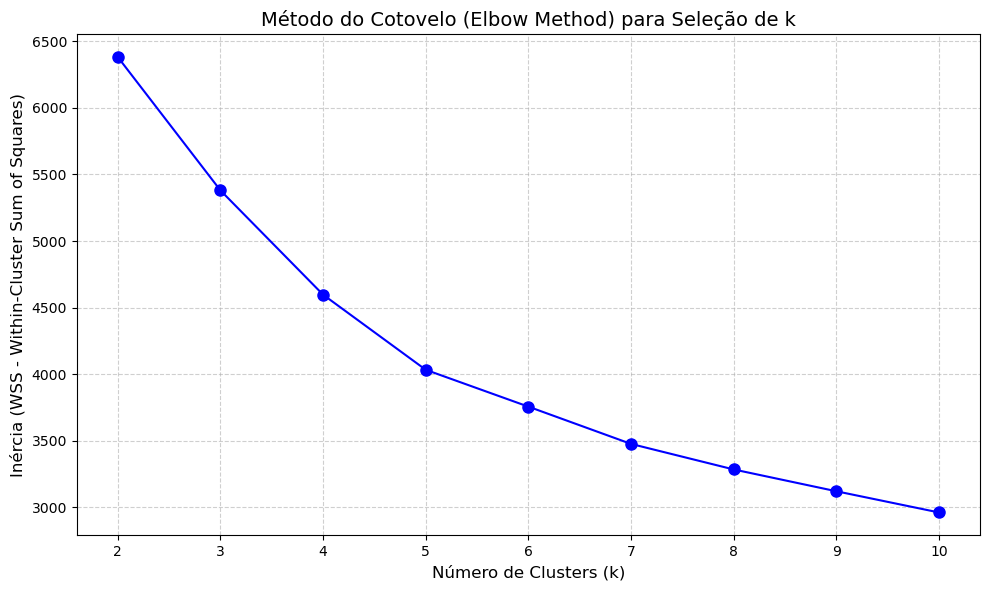

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('../data/nba_2024_scaled.csv')

if 'Player' in df.columns:
    df_scaled = df.drop(columns=['Player'])
else:
    df_scaled = df

k_range = range(2, 11)

inertia_values = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(df_scaled)

    inertia_values.append(kmeans.inertia_)

    labels = kmeans.labels_
    silhouette_avg = silhouette_score(df_scaled, labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, 'bo-', markersize=8)
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Inércia (WSS - Within-Cluster Sum of Squares)', fontsize=12)
plt.title('Método do Cotovelo (Elbow Method) para Seleção de k', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(k_range)
plt.tight_layout()

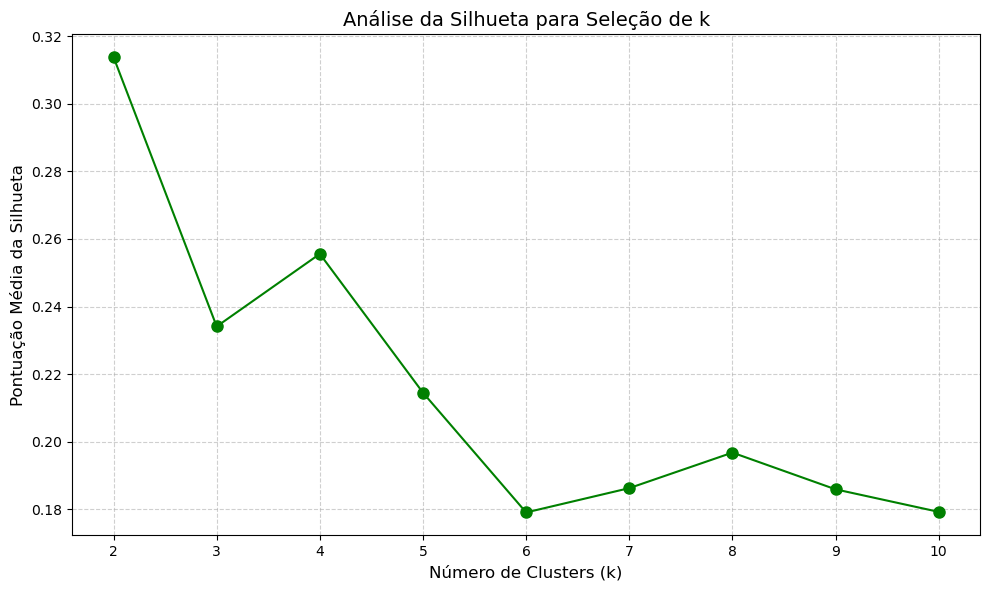

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'go-', markersize=8)
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Pontuação Média da Silhueta', fontsize=12)
plt.title('Análise da Silhueta para Seleção de k', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(k_range)
plt.tight_layout()

RESULTADOS:

c:\Users\luizf\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


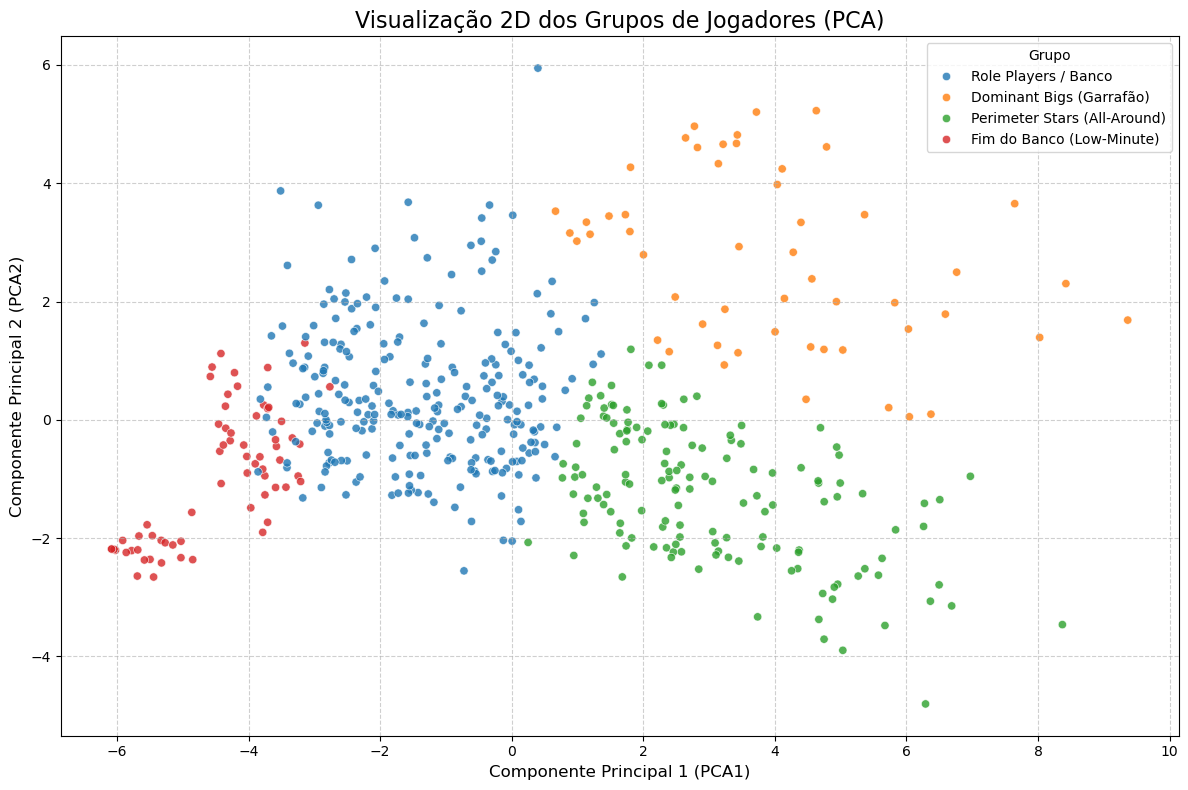

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

df = pd.read_csv('../data/nba_2024_scaled.csv')

if 'Player' in df.columns:
    df_scaled = df.drop(columns=['Player'])
    player_names = df['Player']
else:
    df_scaled = df
    player_names = df_scaled.index

k_ideal = 4
kmeans = KMeans(n_clusters=k_ideal, init='k-means++', n_init=10, random_state=42)
cluster_labels_numeric = kmeans.fit_predict(df_scaled)

cluster_map = {
    0: 'Role Players / Banco',
    1: 'Perimeter Stars (All-Around)',
    2: 'Fim do Banco (Low-Minute)',
    3: 'Dominant Bigs (Garrafão)'
}

cluster_labels_text = pd.Series(cluster_labels_numeric).map(cluster_map)

df_scaled['Cluster_Num'] = cluster_labels_numeric
df_scaled['Grupo'] = cluster_labels_text
df_scaled_with_players['Cluster_Num'] = cluster_labels_numeric
df_scaled_with_players['Grupo'] = cluster_labels_text

df_scaled_with_players.to_csv("../data/nba_2024_with_clusters_named.csv", index=False)

pca = PCA(n_components=2, random_state=42)
pca_components = pca.fit_transform(df_scaled.drop(columns=['Cluster_Num', 'Grupo']))

df_pca = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2'])
df_pca['Grupo'] = cluster_labels_text
df_pca['Player'] = player_names

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='Grupo',
    palette=sns.color_palette('tab10', n_colors=k_ideal),
    data=df_pca,
    legend='full',
    alpha=0.8
)
plt.title(f'Visualização 2D dos Grupos de Jogadores (PCA)', fontsize=16)
plt.xlabel('Componente Principal 1 (PCA1)', fontsize=12)
plt.ylabel('Componente Principal 2 (PCA2)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

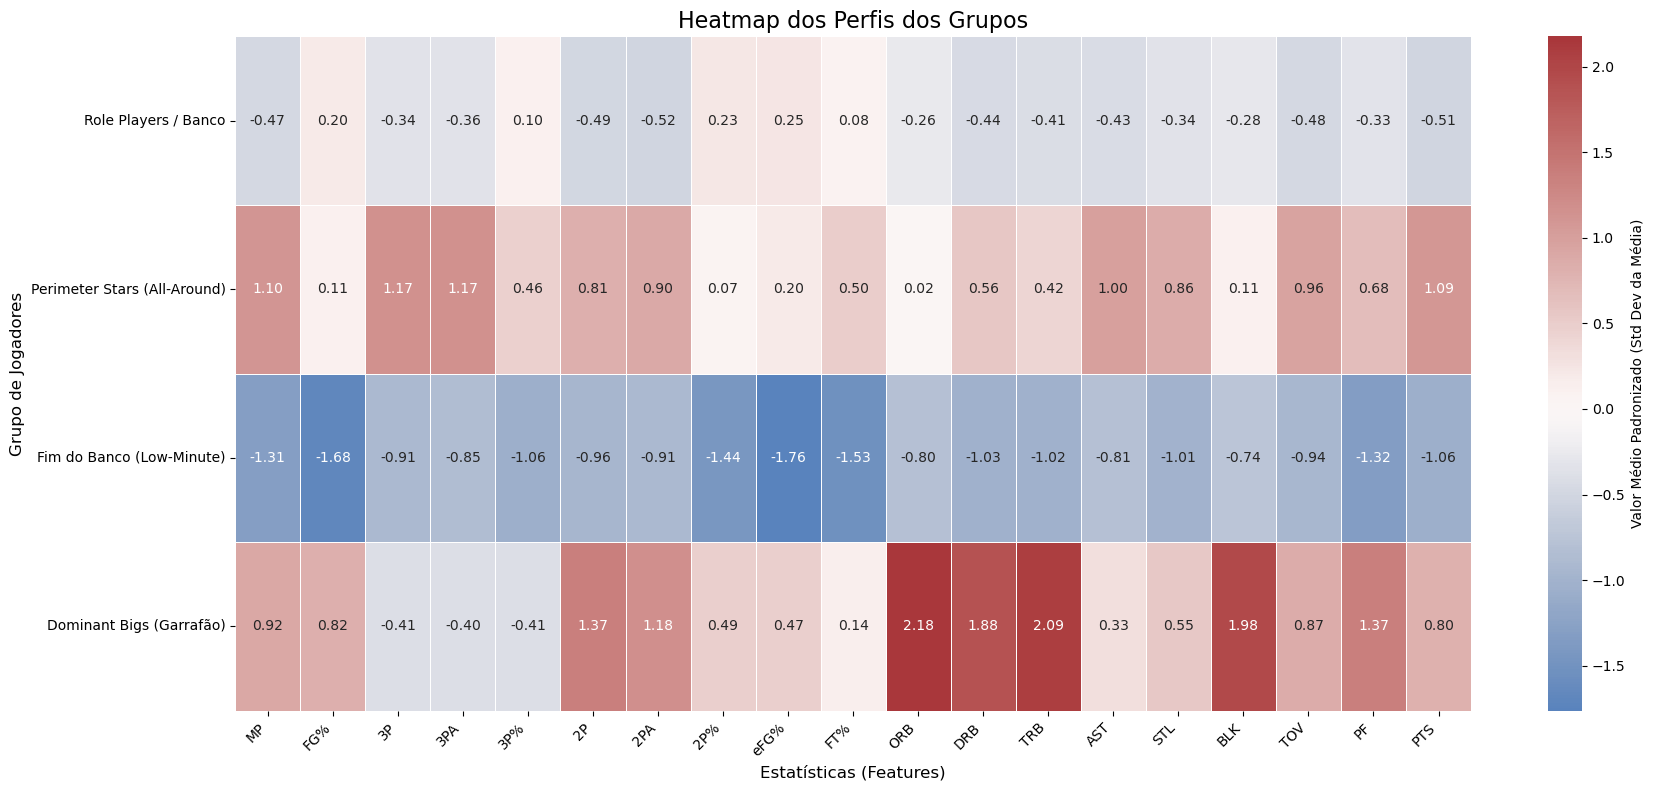

In [9]:
cluster_profiles = df_scaled.drop(columns=['Grupo']).groupby('Cluster_Num').mean()

cluster_profiles = cluster_profiles.rename(index=cluster_map)

plt.figure(figsize=(18, 8))
sns.heatmap(
    cluster_profiles,
    annot=True,
    fmt=".2f",
    cmap='vlag',
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'Valor Médio Padronizado (Std Dev da Média)'}
)
plt.title('Heatmap dos Perfis dos Grupos', fontsize=16)
plt.xlabel('Estatísticas (Features)', fontsize=12)
plt.ylabel('Grupo de Jogadores', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

In [10]:
distances_to_centroids = kmeans.transform(df_scaled.drop(columns=['Cluster_Num', 'Grupo']))

df_results_proto = pd.DataFrame(distances_to_centroids, columns=[f'Dist_C{i}' for i in range(k_ideal)])
df_results_proto['Player'] = player_names
df_results_proto['Cluster_Num'] = cluster_labels_numeric

print("Protótipos de Cada Grupo (Jogador Mais Próximo do Centro)\n")

for cluster_num, cluster_name in cluster_map.items():

    df_cluster_k = df_results_proto[df_results_proto['Cluster_Num'] == cluster_num]

    distance_col_name = f'Dist_C{cluster_num}'

    prototype_index = df_cluster_k[distance_col_name].idxmin()

    prototype_name = df_results_proto.loc[prototype_index]['Player']
    min_distance = df_cluster_k[distance_col_name].min()

    print(f"Grupo: {cluster_name}")
    print(f"  -> Protótipo: {prototype_name}")
    print(f"  -> (Distância ao centro: {min_distance:.4f})\n")

Protótipos de Cada Grupo (Jogador Mais Próximo do Centro)

Grupo: Role Players / Banco
  -> Protótipo: Jordan Nwora
  -> (Distância ao centro: 0.9998)

Grupo: Perimeter Stars (All-Around)
  -> Protótipo: Caris LeVert
  -> (Distância ao centro: 1.2475)

Grupo: Fim do Banco (Low-Minute)
  -> Protótipo: Aleksej Pokusevski
  -> (Distância ao centro: 1.2464)

Grupo: Dominant Bigs (Garrafão)
  -> Protótipo: Jonas Valančiūnas
  -> (Distância ao centro: 1.4048)

